In [1]:
library(CellChat)
library(patchwork)
options(stringsAsFactors = FALSE)
library(Seurat)
#library(SeuratData)
#library(SeuratDisk)
library(reticulate)
use_condaenv("deep")

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject



In [213]:
ad <- import("anndata", convert = FALSE)
# different severities


#dataname = 'severesemi'
#dataname = 'severegt'

#dataname = 'criticalgt'
#dataname = 'criticalsemi'

#dataname = 'moderatesemi'
#dataname = 'moderategt'

#dataname = 'mildgt'
#dataname = 'mildsemi'

#dataname = 'healthysemi'
#dataname = 'healthygt'





#dataname = 'asymptomaticsemi' # did version theshold 0.1 and 0.05

#dataname = 'asymptomaticgt'   # use threshold 0.1 and also 0.05 to be comparable



#dataname = 'nongt'
#dataname = 'nonsemi'



fname = paste('typedata/',dataname,'.h5ad',sep='')

adata <- ad$read_h5ad(fname)#("gt50k.h5ad")#ad$read_h5ad("gtdata.h5ad")

In [214]:
gtx = as.matrix(adata$X)

In [215]:
genes = reticulate::py_to_r(adata$var$index)

In [216]:
genes = c()
for (i in 1:length(adata$var$index)){
    gene = as.character(adata$var$index[i-1])
    genes = c(genes,gene)
}

In [217]:
#adata$obs['initial_clustering']

In [218]:
colnames(gtx) = genes

In [219]:
totalcid = c()

for (i in 1:length(adata$obs$index)){
    cid = as.character(adata$obs$index[i-1])
    totalcid = c(totalcid,cid)
}

In [220]:
ctypes = c()
for (i in 1:length(adata$obs['initial_clustering'])){
    ctype = as.character(adata$obs['initial_clustering'][i-1])
    ctypes = c(ctypes,ctype)
}

In [221]:
row.names(gtx)=totalcid

In [222]:
gtmeta = data.frame(labels = ctypes, row.names = totalcid) 

In [223]:
cellchat <- createCellChat(object = t(gtx), meta = gtmeta, group.by = "labels")

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  B_cell CD14 CD16 CD4 CD8 DCs gdT HSC Lymph_prolif MAIT Mono_prolif NK_16hi NK_56hi pDC Plasmablast Platelets RBC Treg 


In [224]:
CellChatDB <- CellChatDB.human
# use all CellChatDB for cell-cell communication analysis
CellChatDB.use <- CellChatDB # simply use the default CellChatDB
# set the used database in the object
cellchat@DB <- CellChatDB.use

In [225]:
cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database

In [226]:
#future::plan("multisession", workers = 4) # do parallel

In [227]:

cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)

In [228]:
#cellchat <- computeCommunProb(cellchat)

In [229]:
trim = 0.1
cellchat <- computeCommunProb(cellchat, type = "truncatedMean", trim = trim)

truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2023-10-27 18:10:52]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-10-27 18:12:31]"


In [230]:
cellchat <- computeCommunProbPathway(cellchat)

In [231]:
cellchat <- aggregateNet(cellchat)

In [232]:
cellchat <- netAnalysis_computeCentrality(cellchat)#, slot.name = "netP")

In [233]:

#pdf(file='cellchat/severegt.pdf')
#netVisual_heatmap(cellchat, color.heatmap = "Reds")
#dev.off()

In [234]:
#netVisual_heatmap(cellchat, color.heatmap = "Reds")

Do heatmap based on a single object 




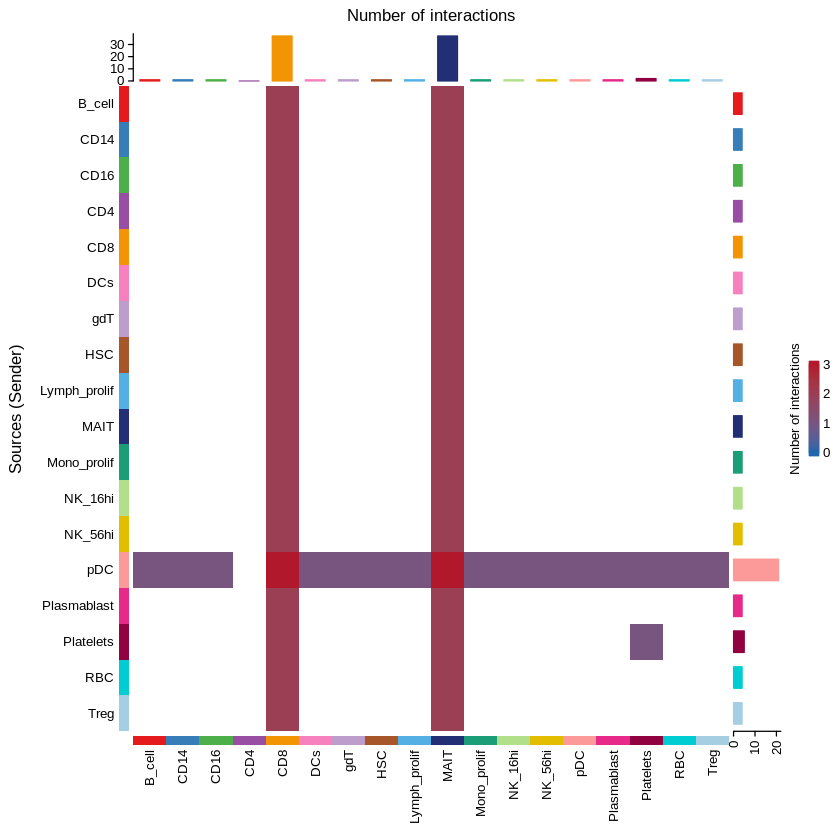

In [235]:
netVisual_heatmap(cellchat)#, color.heatmap = "Reds")

In [236]:
hm = netVisual_heatmap(cellchat)#, color.heatmap = "Reds")
write.csv(hm@matrix, file = paste(fname,'thesh',trim,'.csv',sep=''), row.names = FALSE)

Do heatmap based on a single object 




In [237]:
pdfname = paste('cellchat/',dataname,'thesh',trim,'.csv.pdf',sep='')
pdf(file=pdfname)
netVisual_heatmap(cellchat)#, color.heatmap = "Reds")
dev.off()

Do heatmap based on a single object 




png 
  2

Do heatmap based on a single object 




null device 
          1

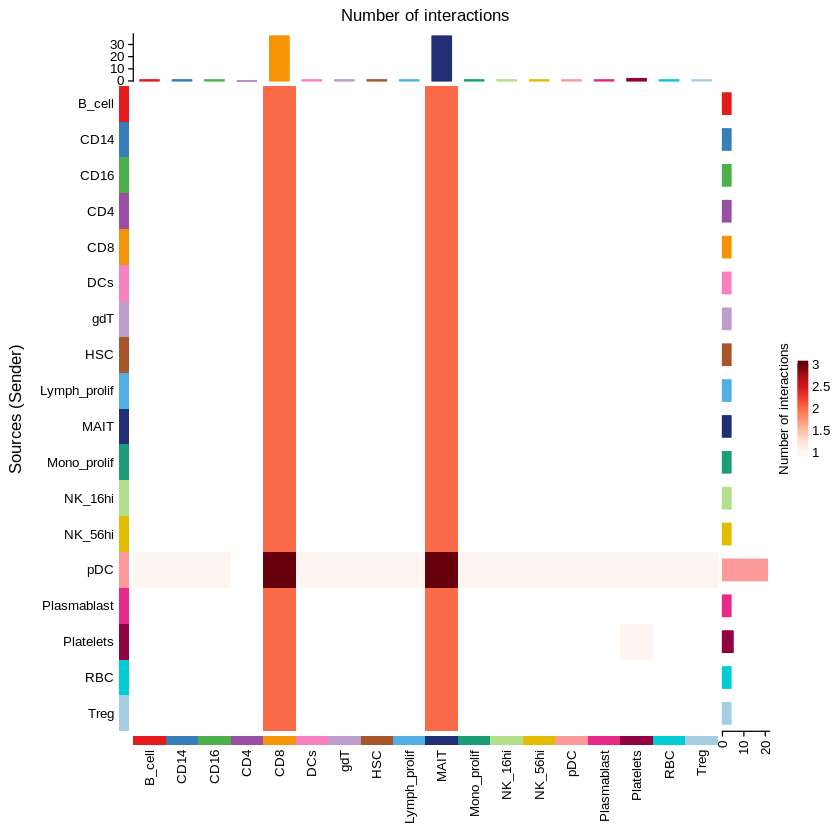

In [238]:
pdfname = paste('cellchat/',dataname,'thesh',trim,'.csvreds.pdf',sep='')
netVisual_heatmap(cellchat, color.heatmap = "Reds")
dev.off()

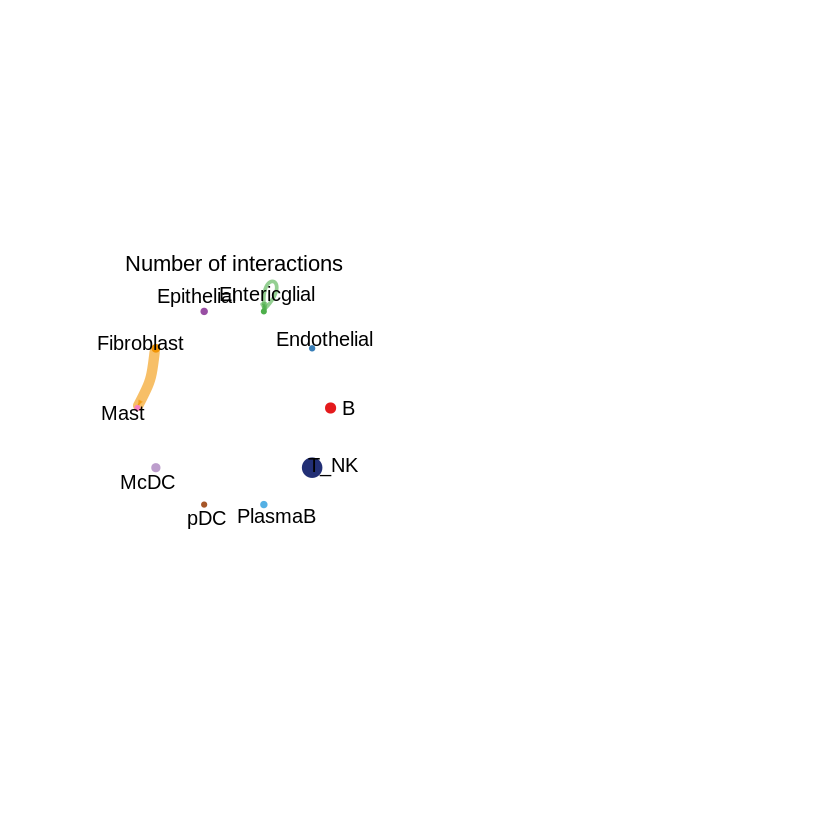

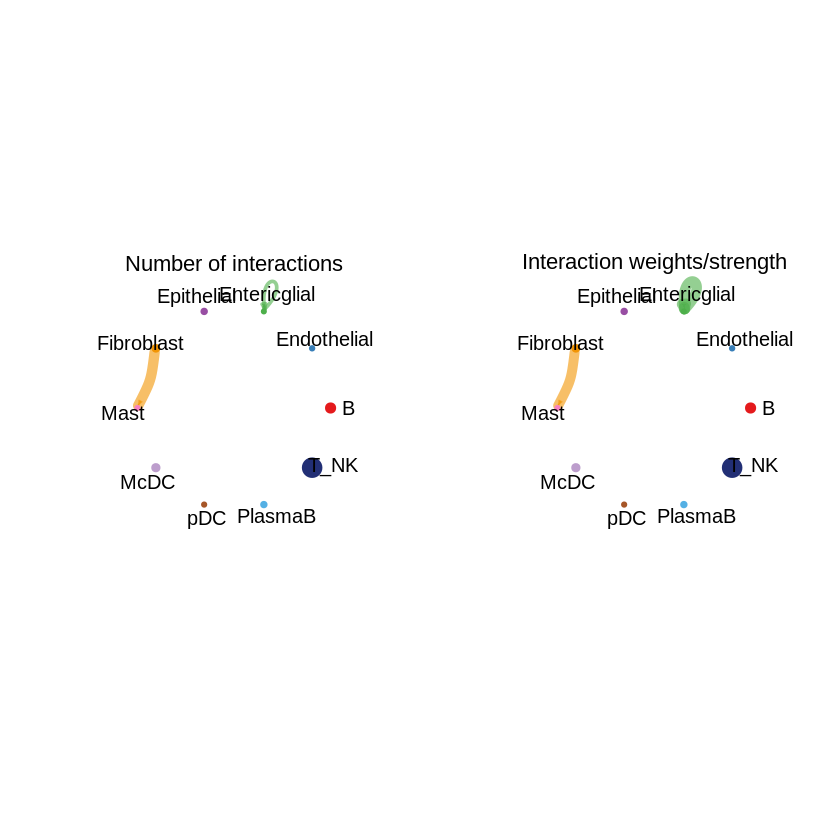

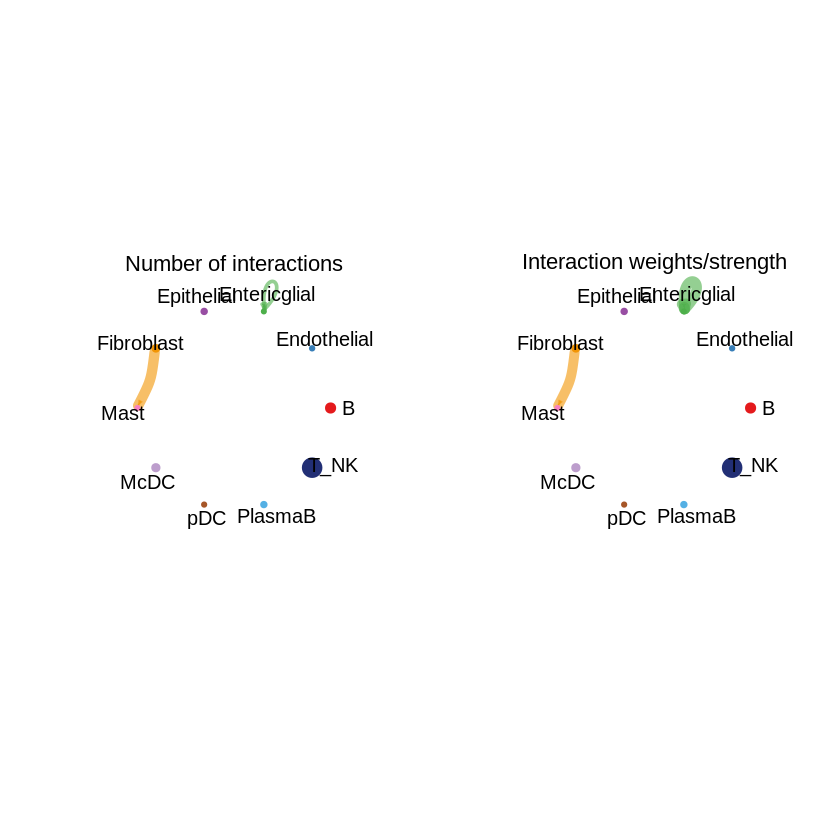

In [22]:
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

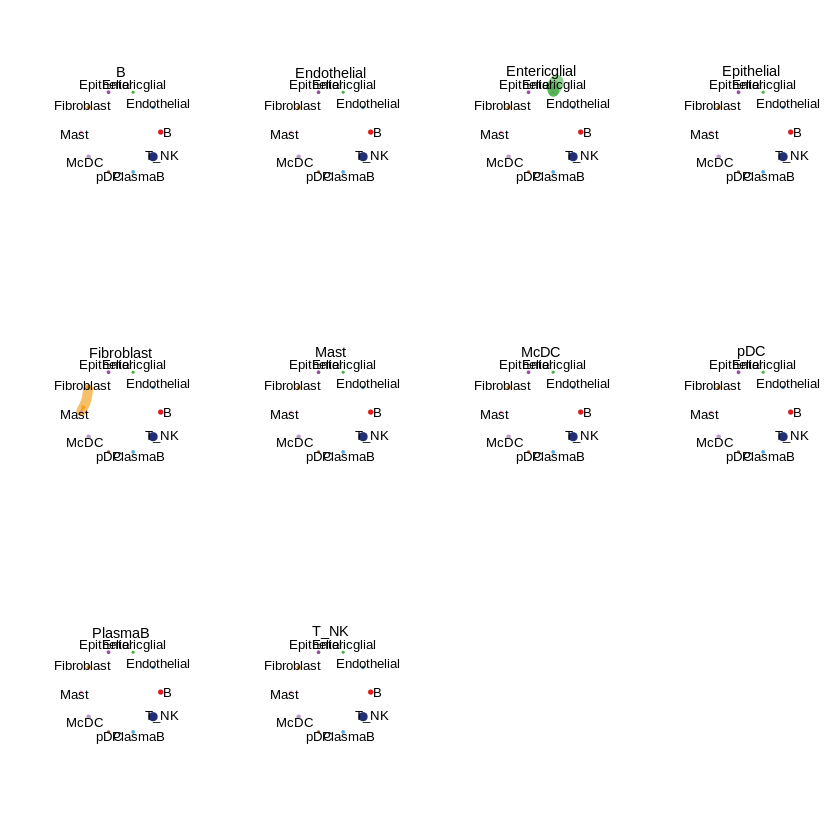

In [23]:
#pdf(file='ground truth interaction by celltype.pdf')
mat <- cellchat@net$weight
par(mfrow = c(3,4), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}
#dev.off()

In [24]:
cellchat@netP$pathways

[1] "MPZ"      "COLLAGEN" "FN1"

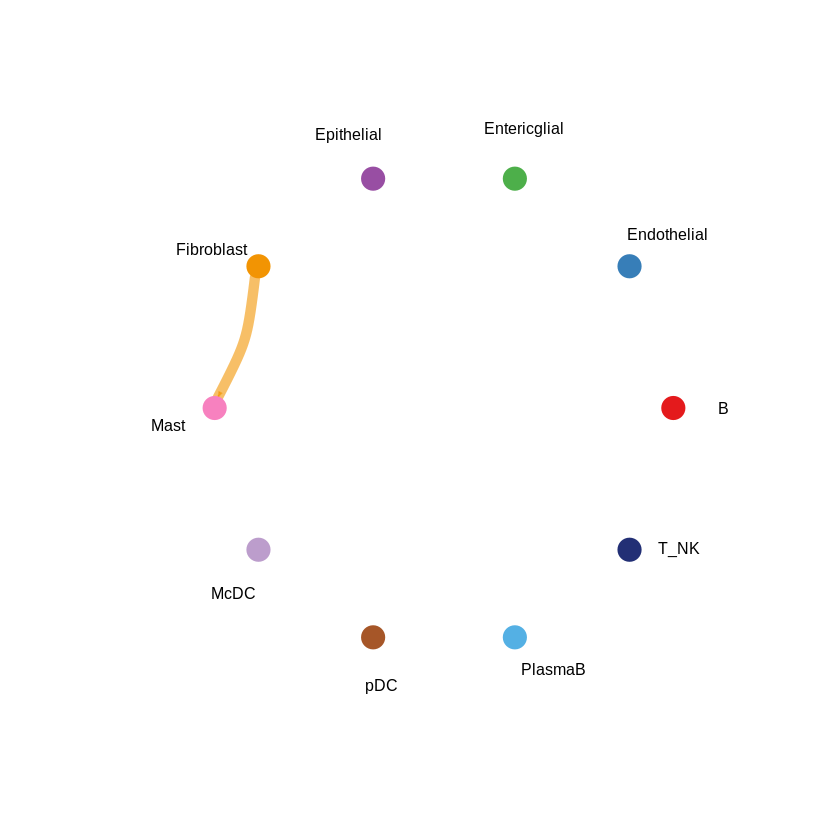

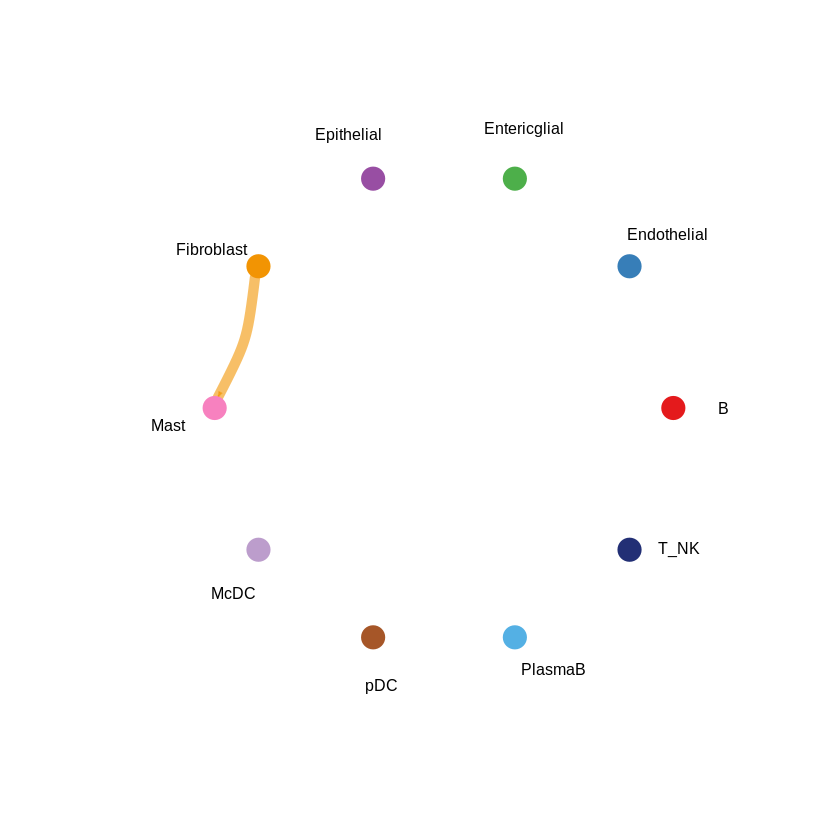

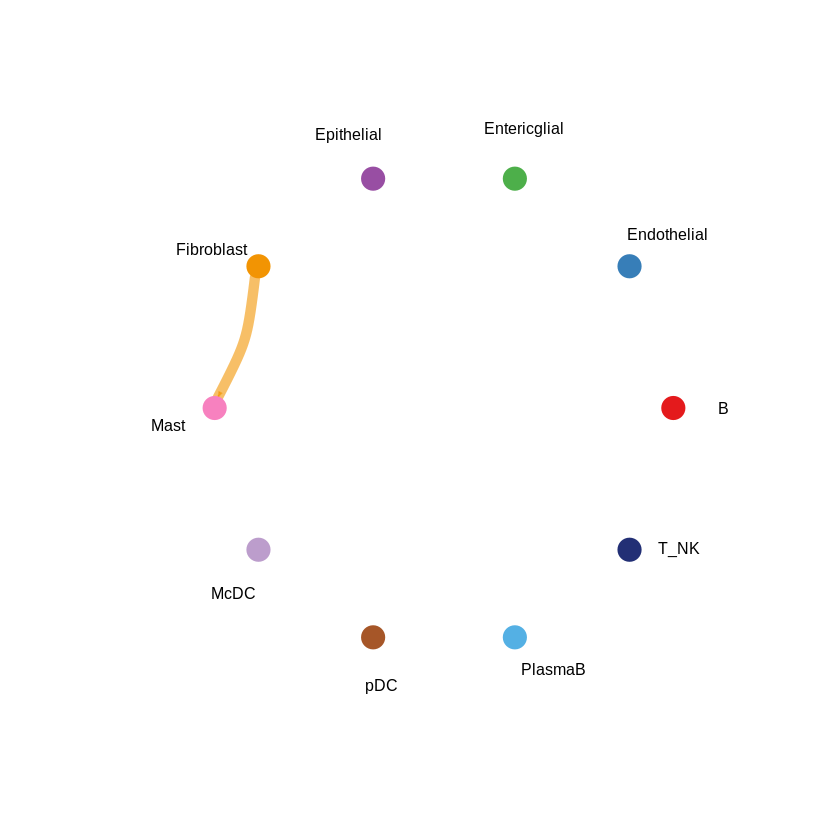

In [25]:
#pdf(file='ground truth MHC-II.pdf')
pathways.show <- c("COLLAGEN") 
vertex.receiver = seq(1,4) # a numeric vector. 
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)

par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")
#dev.off()

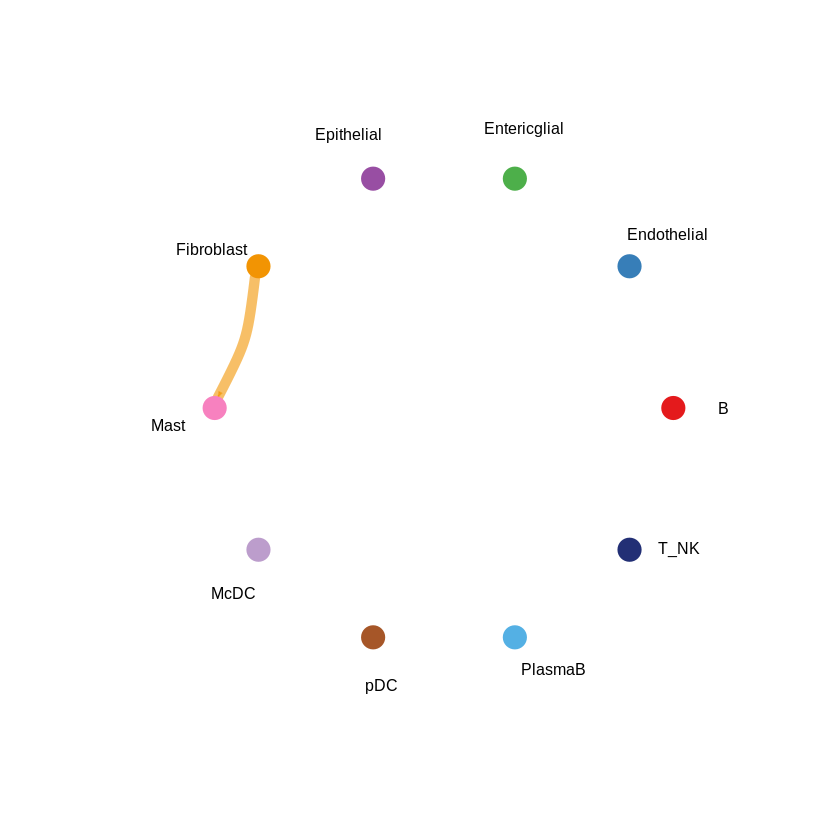

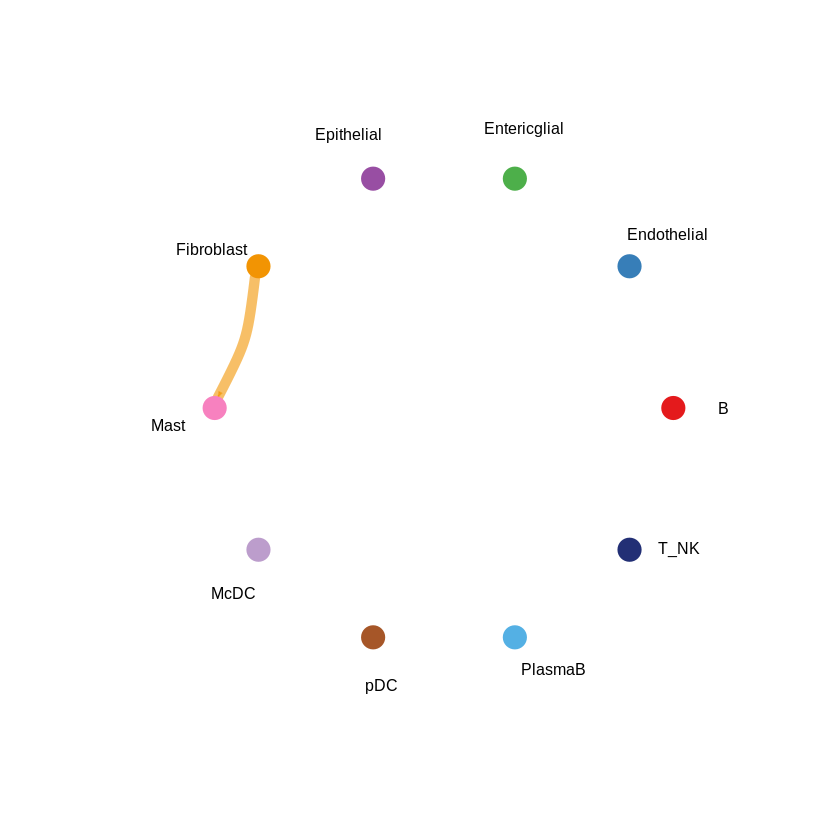

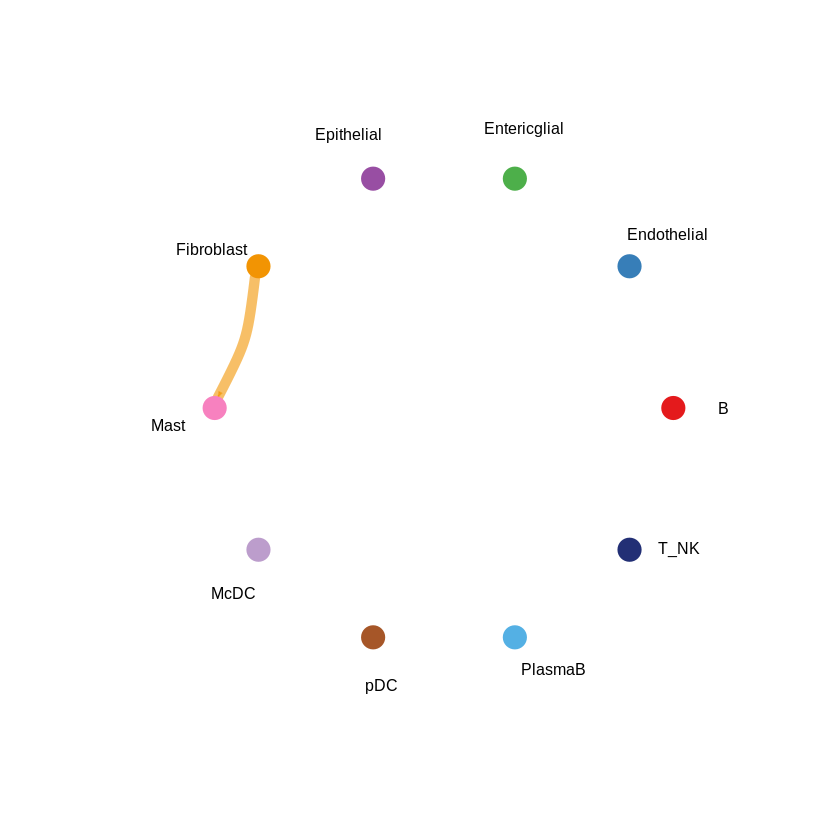

In [26]:
pathways.show <- c("COLLAGEN") 
# Hierarchy plot
# Here we define `vertex.receive` so that the left portion of the hierarchy plot shows signaling to fibroblast and the right portion shows signaling to immune cells 
vertex.receiver = seq(1,4) # a numeric vector. 
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver)
# Circle plot
par(mfrow=c(1,1))
netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle")

In [27]:
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")

In [28]:
#netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, width = 16, height = 5, font.size = 10)

In [29]:
#pdf("ground truth MHC-II heatmap.pdf") 
#netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, width = 16, height = 5, font.size = 10)
#dev.off()

In [30]:
#pdf("ground truth MHC-II heatmap.pdf") 
#netAnalysis_signalingRole_network(cellchat, width = 16, height = 5, font.size = 10)
#dev.off()

In [31]:
#nPatterns = 4
#cellchat <- identifyCommunicationPatterns(cellchat, pattern = "incoming", k = nPatterns)

In [32]:
#ht1 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "outgoing")

In [33]:
#ht1

In [34]:
#ht2 <- netAnalysis_signalingRole_heatmap(cellchat, pattern = "incoming")

In [35]:
#ht2

In [36]:
#pdf('ground truth ligand receptor celltype 1.pdf')
#netVisual_bubble(cellchat, sources.use = 1, targets.use = c(1:18), remove.isolate = FALSE)
#dev.off()

In [37]:
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")
pdf('cellchat/pathwaygt_LymphNode.pdf',width=15, height=8)
netVisual_bubble(cellchat, sources.use = (1:18), targets.use = c(1:18), remove.isolate = FALSE)
dev.off()

Comparing communications on a single object 




png 
  2

In [38]:
#pathway.shpw='APP'

In [39]:
#par(mfrow=c(1,1))
ccp = netVisual_heatmap(cellchat, color.heatmap = "Reds")

Do heatmap based on a single object 




In [40]:
pdf(file='cellchat/CCI-gt-LymphNode.pdf')
netVisual_heatmap(cellchat, color.heatmap = "Reds")
dev.off()

Do heatmap based on a single object 




png 
  2

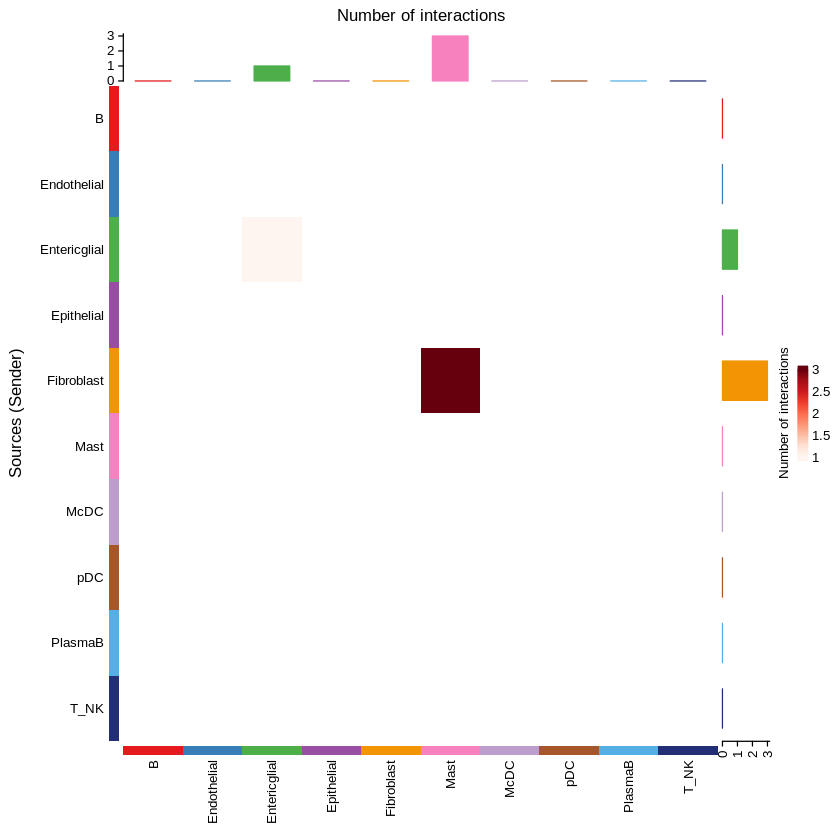

In [41]:
ccp

In [42]:
1+1

[1] 2